### Problem Formulation

## GOAL
 Identify deletion and duplication breakpoints in a particular gene in 3 ethnicities

- A duplication is a region where the individual has more than 2 copies of dna
- A deletion is a region where the individual has less than 2 copies of dna
- A breakpoint is the last region before or first region after a series of deletions or duplications

## How the measurements are done

- Probes output the number of times dna is read by the probe at a certain region, called read-depth
- The read-depth of a probe is (approximately) linear in the number of dna copies
- Each probe has a different efficiency but has the same efficiency on all individuals
- Each sample has a different average read-depth across all probes

In [44]:
# import necessary libraries

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import seaborn as sns

## Load and explore data

In [45]:
df = pd.read_csv('cnsl_data.csv', index_col=0)

Check data for missing values

In [46]:
df.isna().sum().sum()

0

Split the data into 3 parts: cnsl data, control data and ethnicity of the subjects

In [47]:
cnsl_df = df.iloc[:,1:51]
ctrl_df = df.iloc[:,51:]
ethnicities = df.ethnicity

In [48]:
cnsl_df.head()

,CNSL_probe_0,CNSL_probe_1,CNSL_probe_2,CNSL_probe_3,CNSL_probe_4,CNSL_probe_5,CNSL_probe_6,CNSL_probe_7,CNSL_probe_8,CNSL_probe_9,...,CNSL_probe_40,CNSL_probe_41,CNSL_probe_42,CNSL_probe_43,CNSL_probe_44,CNSL_probe_45,CNSL_probe_46,CNSL_probe_47,CNSL_probe_48,CNSL_probe_49
0,410,233,697,167,131,77,520,132,161,555,...,409.0,465,130,188,175,215,503,122,352,202
1,557,304,956,208,138,106,678,173,218,718,...,580.0,624,179,238,225,300,532,183,485,250
2,487,260,861,194,148,94,617,191,205,693,...,586.0,589,197,243,213,261,534,166,523,265
3,686,368,1276,267,221,1114,884,206,273,830,...,729.0,858,234,313,317,341,1099,205,675,328
4,677,348,1248,267,179,268,856,225,305,843,...,757.0,742,271,345,302,414,736,225,586,354


In [49]:
ethnicity_counts = ethnicities.value_counts()
ethnicity_counts

ethnicity
A    4988
B    2543
C    2469
Name: count, dtype: int64

The main idea behind my cnv calling method is that a given subject will have similar read-depths on probes with similar efficiency. 

 1) Use mean read-depths of probes to estimate the efficiencies of the probes
 2) Determine the linear relationship between mean read-depth of probes and read-depths on each individual(this will account for the efficiency of each individual)
 3) Use mean read-depth of probes from the control group and the linear functions fitted in the previous step to estimate expected read-depths for each individual.


In [50]:
ctrl_mean_probe_depth = ctrl_df.mean(axis=0) 
cnsl_mean_probe_depth = cnsl_df.mean()

Plot to visualize read depth range in the control group and how it changes with mean probe read-depth

Text(0, 0.5, 'read-depth')

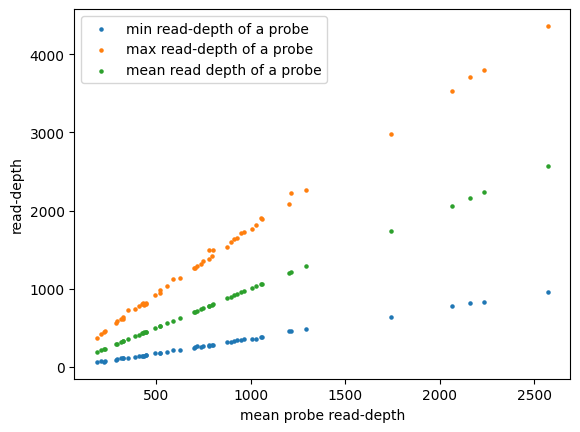

In [51]:

min_values = ctrl_df.min()  
max_values = ctrl_df.max()

plt.scatter(ctrl_mean_probe_depth, min_values, s=5, label='min read-depth of a probe')
plt.scatter(ctrl_mean_probe_depth, max_values, s=5, label='max read-depth of a probe')
plt.scatter(ctrl_mean_probe_depth, ctrl_mean_probe_depth, s=5, label='mean read depth of a probe')
plt.legend()
plt.xlabel('mean probe read-depth')
plt.ylabel('read-depth')


Plot to compare the read depths of the first subject

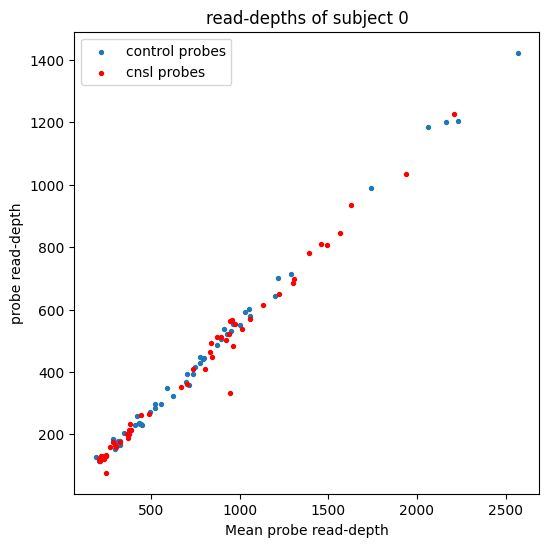

In [52]:
plt.figure(figsize=(6,6))
j = 0

plt.scatter(ctrl_mean_probe_depth, ctrl_df.iloc[j,:], s=8, label='control probes')
plt.scatter(cnsl_mean_probe_depth, cnsl_df.iloc[j,:], s=8, color='red', label='cnsl probes')

plt.xlabel('Mean probe read-depth')
plt.ylabel('probe read-depth')
plt.title('read-depths of subject 0')
plt.legend()

Same plot for the subject 24 who has a number of duplications

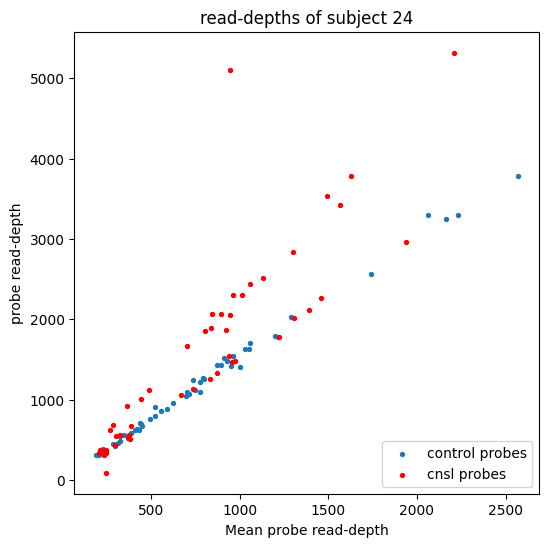

In [53]:
plt.figure(figsize=(6,6))
j = 24

plt.scatter(ctrl_mean_probe_depth, ctrl_df.iloc[j,:], s=8, label='control probes')
plt.scatter(cnsl_mean_probe_depth, cnsl_df.iloc[j,:], s=8, color='red', label='cnsl probes')

plt.xlabel('Mean probe read-depth')
plt.ylabel('probe read-depth')
plt.title('read-depths of subject 24')
plt.legend()

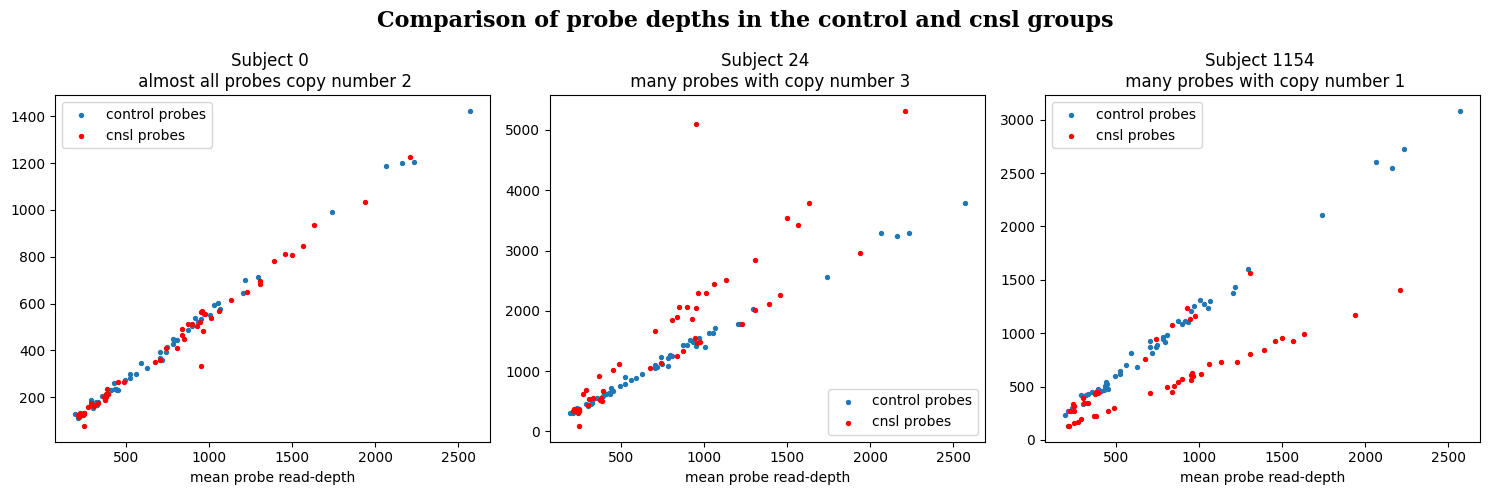

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 

# Plot scatterplots on each subplot
axs[0].scatter(ctrl_mean_probe_depth, ctrl_df.iloc[0,:], s=8, label='control probes')
axs[0].scatter(cnsl_mean_probe_depth, cnsl_df.iloc[0,:], s=8, color='red', label='cnsl probes')
axs[1].scatter(ctrl_mean_probe_depth, ctrl_df.iloc[24,:], s=8, label='control probes')
axs[1].scatter(cnsl_mean_probe_depth, cnsl_df.iloc[24,:], s=8, color='red', label='cnsl probes')
axs[2].scatter(ctrl_mean_probe_depth, ctrl_df.iloc[1154,:], s=8, label='control probes')
axs[2].scatter(cnsl_mean_probe_depth, cnsl_df.iloc[1154,:], s=8, color='red', label='cnsl probes')


# Set titles and labels
fig.suptitle('Comparison of probe depths in the control and cnsl groups', fontsize=16, fontweight='bold', fontfamily='serif', color='black')

axs[0].set_title('Subject 0 \n almost all probes copy number 2')
axs[0].set_xlabel('mean probe read-depth')
axs[0].legend()

axs[1].set_title('Subject 24 \n many probes with copy number 3')
axs[1].set_xlabel('mean probe read-depth')
axs[1].legend()

axs[2].set_title('Subject 1154 \n many probes with copy number 1')
axs[2].set_xlabel('mean probe read-depth')
axs[2].legend()

fig.tight_layout()

## Estimation of probe read-depths using the control group

In [55]:
# for each subject fit a line to read-depths in the control group
# use the line to estimate the expected depths in the test group

cnsl_expected_depth_df = cnsl_df.copy().astype(float)
param_coef = [0]*10000
param_var = [0]*10000

def lin_fit(x, a):
    return a*x

for i in range(10000):
    param_coef[i], param_var[i] = curve_fit(lin_fit, ctrl_mean_probe_depth, ctrl_df.iloc[i,:])
    cnsl_expected_depth_df.iloc[i,:] = param_coef[i]*cnsl_mean_probe_depth
    

## Call variants on the test group

In [56]:
# Use multipliers to decide how much probe depths differ from expected depths and classify them

cnsl_multipliers = cnsl_df/cnsl_expected_depth_df

def call_variants(x):
    if x > 2:
        return 4
    elif x > 1.2:
        return 3
    elif x > .7:
        return 2
    elif x > .2:
        return 1
    else:
        return 0

cnsl_cnv = cnsl_multipliers.apply(lambda x:x.apply(call_variants), axis=1)

## Inspection of cnvs called

Check for 0 read depths in the cnsl group

In [57]:
cnsl_zero = (cnsl_df == 0).sum()
cnsl_zero = cnsl_zero[cnsl_zero > 0]
cnsl_zero

CNSL_probe_5    76
dtype: int64

Check the number of 2 cnv called on probes in the cnsl group  

In [58]:
(cnsl_cnv == 2).sum(axis=0).sort_values(ascending=True).head()

CNSL_probe_5     1978
CNSL_probe_46    3796
CNSL_probe_23    3882
CNSL_probe_32    9501
CNSL_probe_34    9523
dtype: int64

Check for 0 and 4 cnv

In [59]:
((cnsl_cnv == 0) | (cnsl_cnv==4)).sum(axis=0).sort_values(ascending=False).head()

CNSL_probe_5     3274
CNSL_probe_46     622
CNSL_probe_23     584
CNSL_probe_0        0
CNSL_probe_37       0
dtype: int64

Probes 5, 23 and 46 doesn not function correctly. They report too few 2 cnv and too many 0 and 4. Remove them from data

In [60]:
cnsl_cnv = cnsl_cnv.drop(['CNSL_probe_5','CNSL_probe_23','CNSL_probe_46'], axis=1)

## Find the indexes of the subjects that have a potential deletion or duplication

In [61]:
del_dup_ids = ((cnsl_cnv != 2).sum(axis=1) >3)
del_dup_ids = del_dup_ids[del_dup_ids].index

In [62]:
del_dup_ids

Index([  24,   31,   35,   47,   58,   93,  140,  163,  234,  238,
       ...
       9756, 9827, 9844, 9850, 9883, 9887, 9903, 9926, 9968, 9970],
      dtype='int64', length=477)

In [63]:
# write the calls to file 
cnsl_cnv.to_csv('cnsl_cnv_calls.csv')

In [64]:
# subjects with potential deletions or duplications

cnsl_calls = cnsl_cnv.iloc[del_dup_ids,:]

In [65]:
# Number of subjects with a duplications

(cnsl_calls == 3).sum(axis=1).value_counts()

0     141
20    118
30     58
7      57
8      54
9      12
21     11
1      10
31      7
29      4
22      2
2       1
19      1
6       1
Name: count, dtype: int64

In [66]:
# Number of subjects with deletions

(cnsl_calls == 1).sum(axis=1).value_counts()

0     325
8      56
7      56
20     26
30     14
Name: count, dtype: int64

Find the individuals with deletions or duplications known in the literature

In [67]:
brk_10_40_del = (cnsl_calls.iloc[:,8:40] == [2]+[1]*30+[2]).sum(axis=1) == 32
brk_10_40_del = brk_10_40_del.index[brk_10_40_del]

brk_10_40_dup = (cnsl_calls.iloc[:,8:40] == [2]+[3]*30+[2]).sum(axis=1) == 32
brk_10_40_dup = brk_10_40_dup.index[brk_10_40_dup]

brk_20_40_del = (cnsl_calls.iloc[:,18:40] == [2]+[1]*20+[2]).sum(axis=1) == 22
brk_20_40_del = brk_20_40_del.index[brk_20_40_del]

brk_20_40_dup = (cnsl_calls.iloc[:,18:40] == [2]+[3]*20+[2]).sum(axis=1) == 22
brk_20_40_dup = brk_20_40_dup.index[brk_20_40_dup]

brk_27_34_del = (cnsl_calls.iloc[:,24:34] == [2]+[1]*8+[2]).sum(axis=1) == 10
brk_27_34_del = brk_27_34_del.index[brk_27_34_del]

brk_27_34_dup = (cnsl_calls.iloc[:,24:34] == [2]+[3]*8+[2]).sum(axis=1) == 10
brk_27_34_dup = brk_27_34_dup.index[brk_27_34_dup]

brk_32_38_del = (cnsl_calls.iloc[:,29:38] == [2]+[1]*7+[2]).sum(axis=1) == 9
brk_32_38_del = brk_32_38_del.index[brk_32_38_del]

brk_32_38_dup = (cnsl_calls.iloc[:,29:38] == [2]+[3]*7+[2]).sum(axis=1) == 9
brk_32_38_dup = brk_32_38_dup.index[brk_32_38_dup]


In [68]:
# record the new results

del_10_40_df = pd.DataFrame({'ethnicity':ethnicities[brk_10_40_del], 'break_points': '10-40', 'type':'deletion'})
dup_10_40_df = pd.DataFrame({'ethnicity':ethnicities[brk_10_40_dup], 'break_points': '10-40', 'type':'duplication'})
del_20_40_df = pd.DataFrame({'ethnicity':ethnicities[brk_20_40_del], 'break_points': '20-40', 'type':'deletion'})
dup_20_40_df = pd.DataFrame({'ethnicity':ethnicities[brk_20_40_dup], 'break_points': '20-40', 'type':'duplication'})
del_27_34_df = pd.DataFrame({'ethnicity':ethnicities[brk_27_34_del], 'break_points': '27-34', 'type':'deletion'})
dup_27_34_df = pd.DataFrame({'ethnicity':ethnicities[brk_27_34_dup], 'break_points': '27-34', 'type':'duplication'})
del_32_38_df = pd.DataFrame({'ethnicity':ethnicities[brk_32_38_del], 'break_points': '32-38', 'type':'deletion'})
dup_32_38_df = pd.DataFrame({'ethnicity':ethnicities[brk_32_38_dup], 'break_points': '32-38', 'type':'duplication'})


In [69]:
# combine the results into one dataframe

results_df = pd.concat([del_10_40_df, dup_10_40_df, del_20_40_df, dup_20_40_df, del_27_34_df, dup_27_34_df, del_32_38_df, dup_32_38_df], axis=0)

Summarize results

In [70]:
results_summary_df = results_df.groupby(['ethnicity','break_points','type']).agg(count=('ethnicity', 'count')).reset_index()
results_summary_df

,ethnicity,break_points,type,count
0,A,27-34,deletion,55
1,A,27-34,duplication,60
2,A,32-38,deletion,57
3,A,32-38,duplication,62
4,B,20-40,deletion,26
5,B,20-40,duplication,131
6,C,10-40,deletion,14
7,C,10-40,duplication,65


## Identify the subjects that have deletions or duplications that do not fit the hard coded break points

In [71]:
not_covered_ids = [id for id in del_dup_ids if id not in results_df.index]
not_covered_ids


[2791, 3513, 5259, 6169, 6626, 8424, 9263]

In [72]:
# the number of duplications for each individual
(cnsl_calls.loc[not_covered_ids, :] == 3).sum(axis=1).sort_values(ascending=False) 


2791    29
3513    29
5259    29
6626    29
6169    19
9263     9
8424     6
dtype: int64

In [73]:
# the number of deletions for each individual
(cnsl_calls.loc[not_covered_ids, :] == 1).sum(axis=1).sort_values(ascending=False)

2791    0
3513    0
5259    0
6169    0
6626    0
8424    0
9263    0
dtype: int64

The above two cells show that there are no deletions, only duplications. Also the number of duplications is 1 more or less than the number of probes between the breakpoint, suggesting that one probe had a off-reading. 

These 7 subjects has all duplications in the given areas except for 1 probe, or in one case the subject has an extra probe that is not within the breakpoints and reported a duplication. The probes that do not report duplications or report an extra duplication are all low coverage probes. I am adding these results to the exact fits, as the factors are missing the boundaries I set by a narrow margin and nationalities also align with the other results.

In [74]:
# add the individuals with one probe off reading to the results 
# by matching them with the closest hard-coded region

results_2_df = pd.DataFrame({'ethnicity':ethnicities[not_covered_ids], 
                             'break_points':(cnsl_calls.loc[not_covered_ids,:]==3).sum(axis=1), 
                             'type':'duplication'})
results_2_df['break_points'] = results_2_df.break_points.astype('str')
results_2_df.loc[results_2_df.break_points=='29','break_points']='10-40'
results_2_df.loc[results_2_df.break_points=='19','break_points']='20-40'
results_2_df.loc[results_2_df.break_points=='6','break_points']='32-38'
results_2_df.loc[results_2_df.break_points=='9','break_points']='27-34'

In [75]:
results_2_df

,ethnicity,break_points,type
2791,C,10-40,duplication
3513,C,10-40,duplication
5259,C,10-40,duplication
6169,B,20-40,duplication
6626,C,10-40,duplication
8424,A,32-38,duplication
9263,A,27-34,duplication


Add the new results to the previous ones

In [76]:
results = pd.concat([results_df, results_2_df], axis=0)

In [77]:
results

,ethnicity,break_points,type
1154,C,10-40,deletion
1874,C,10-40,deletion
1883,C,10-40,deletion
2998,C,10-40,deletion
3004,C,10-40,deletion
...,...,...,...
5259,C,10-40,duplication
6169,B,20-40,duplication
6626,C,10-40,duplication
8424,A,32-38,duplication


In [78]:
results_summary = results.groupby(['ethnicity','break_points','type']).agg(total=('ethnicity', 'count')).reset_index()
results_summary

,ethnicity,break_points,type,total
0,A,27-34,deletion,55
1,A,27-34,duplication,61
2,A,32-38,deletion,57
3,A,32-38,duplication,63
4,B,20-40,deletion,26
5,B,20-40,duplication,132
6,C,10-40,deletion,14
7,C,10-40,duplication,69


Check that all of the 477 subjects that had a duplication or deletion are in the results table

In [79]:
results_summary.total.sum()

477

## Summarize and plot results

In [80]:
results_summary['ethnicity and break_point'] = results_summary['ethnicity'] + ' at ' + results_summary['break_points']
results_summary['ethnicity population'] = results_summary.ethnicity.apply(lambda eth:ethnicity_counts[eth])
results_summary['del_dup_frequency'] = results_summary['total']/results_summary['ethnicity population']

In [81]:
results_summary

,ethnicity,break_points,type,total,ethnicity and break_point,ethnicity population,del_dup_frequency
0,A,27-34,deletion,55,A at 27-34,4988,0.011026
1,A,27-34,duplication,61,A at 27-34,4988,0.012229
2,A,32-38,deletion,57,A at 32-38,4988,0.011427
3,A,32-38,duplication,63,A at 32-38,4988,0.012630
4,B,20-40,deletion,26,B at 20-40,2543,0.010224
5,B,20-40,duplication,132,B at 20-40,2543,0.051907
6,C,10-40,deletion,14,C at 10-40,2469,0.005670
7,C,10-40,duplication,69,C at 10-40,2469,0.027947


Text(0, 0.5, 'Frequency')

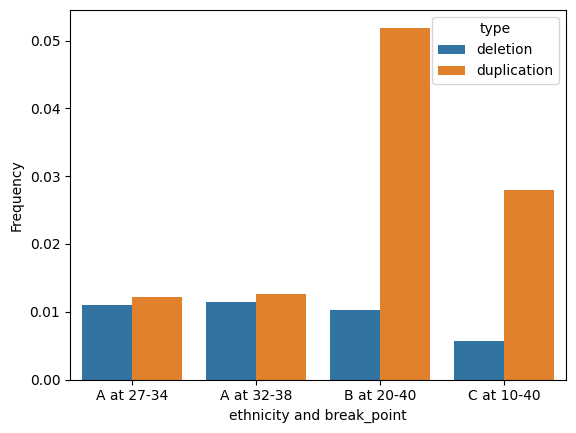

In [82]:
sns.barplot(data=results_summary, x='ethnicity and break_point', y='del_dup_frequency', hue='type')

plt.ylabel('Frequency')

In [83]:
results_summary.iloc[:,[0,1,2,3,6]].rename({'del_dup_frequency':'frequency'}, axis=1)

,ethnicity,break_points,type,total,frequency
0,A,27-34,deletion,55,0.011026
1,A,27-34,duplication,61,0.012229
2,A,32-38,deletion,57,0.011427
3,A,32-38,duplication,63,0.012630
4,B,20-40,deletion,26,0.010224
5,B,20-40,duplication,132,0.051907
6,C,10-40,deletion,14,0.005670
7,C,10-40,duplication,69,0.027947
